# Actividad evaluable del módulo 3: Clasificación del conjunto de datos MNIST

Ahora que hemos aprendido a utilizar todo lo que nos ofrece PyTorch, vamos a clasificar un conjunto de datos específico. Más concretamente, construiremos un clasificador para el conjunto de datos MNIST de cifras escritas a mano (https://en.wikipedia.org/wiki/MNIST_database). Este conjunto contiene decenas de miles de cifras entre 0 y 9 escritas a mano, y se suele utilizar a menudo para entrenar algoritmos de *machine learning*. En esta actividad, le proporcionaremos código básico para cargar los datos y deberá construir una red neuronal profunda entrenada con este conjunto de datos. Le animamos a reutilizar el código que haya escrito o visto en los cuadernos anteriores.

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import time, copy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

# Configuración del dispositivo (si es posible, entrene el modelo con la GPU, el proceso será mucho más rápido)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Primero, cargaremos el conjunto de datos MNIST. PyTorch ofrece una serie de funciones integradas para cargar conjuntos de imágenes de uso frecuente, entre ellos MNIST.

In [2]:
# Estas transformaciones se aplicarán a todos los puntos de datos. En este ejemplo, queremos transformarlos
# todos al tipo de datos Tensor
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
mnist_train = torchvision.datasets.MNIST('', train=True, transform =transform, download=True)
# Vamos a dividir el conjunto de datos de entrenamiento en entrenamiento y validación
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000])
mnist_test = torchvision.datasets.MNIST('', train=False, transform = transform, download=True)


100%|██████████| 9912422/9912422 [00:00<00:00, 71145602.13it/s]


Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 57112538.34it/s]


Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24013928.70it/s]


Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8028035.72it/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



In [3]:
# Crearemos DataLoaders, igual que hicimos antes, y el tamaño de los lotes será de 100
batch_size = 100
dataloaders = {'train': DataLoader(mnist_train, batch_size=batch_size),
               'val': DataLoader(mnist_val, batch_size=batch_size),
               'test': DataLoader(mnist_test, batch_size=batch_size)}

dataset_sizes = {'train': len(mnist_train),
                 'val': len(mnist_val),
                 'test': len(mnist_test)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 50000, 'val': 10000, 'test': 10000}


In [4]:
# Una pista: En el cuaderno "Módulo 3: Introducción a PyTorch",
# la red que creamos requería que los datos de input tuvieran la forma Nx1, donde N es el número de atributos.
# El conjunto de datos MNIST tiene una forma de 28 x 28, porque se trata de imágenes.
# Utilice este fragmento de código a medida que vaya iterando los puntos de datos del conjunto
# para aplanarlos, de manera que tengan un tamaño de 784 x 1 y se puedan utilizar con los modelos que ya hemos diseñado.

# Este bucle solo itera por los puntos de datos de entrenamiento.
# En el cuaderno anterior

def train_model(model, dataloaders, dataset_sizes,criterion,optimizer,scheduler,num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  best_epoch = 0
  phases = ["train", "val", "test"]

  training_curves={}
  for phase in phases:
    training_curves[phase+'_loss']=[]
    training_curves[phase+'_acc'] =[]

  for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-'*10)
    for phase in phases:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      for inputs, labels in dataloaders[phase]:
        # Esto aplanará todos los lotes para que tengan el tamaño correcto
        inputs = inputs.view(inputs.shape[0],-1)
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, predictions = torch.max(outputs, 1)
          loss = criterion(outputs, labels)
          # Método backward y actualización de los pesos solo si está en la fase de entrenamiento
          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(predictions == labels.data)

      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]
      training_curves[phase+'_loss'].append(epoch_loss)
      training_curves[phase+'_acc'].append(epoch_acc)

      print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

      if phase == 'val' and epoch_acc > best_acc:
        best_epoch = epoch
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

  time_elapsed = time.time() - since
  print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch}')

  model.load_state_dict(best_model_wts)
  return model, training_curves



In [33]:
# Configuración del dispositivo (si es posible, entrenar el modelo en la GPU, el proceso será mucho más rápido)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hiperparámetros

# Arquitectura del modelo
input_size = 784 # Asegurar que se ellimina la columna index
hidden_size1 =128  #140
hidden_size2 = 64 #30
hidden_size3 = 64 #20
num_classes = 10
dropout = .25

# Parámetros de entrenamiento externos
batch_size = 100
learning_rate = 0.01
num_epochs = 30

In [34]:
# ESCRIBA AQUÍ SU CÓDIGO
# Modelo de clasificación simple de dos capas ocultas
class SimpleClassifier2Layer(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes,dropout):
        super(SimpleClassifier2Layer, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            self.dropout,
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            self.dropout,
            nn.Linear(hidden_size2, num_classes),
        )

    def forward(self, x):
        return self.layers(x)

modelo = SimpleClassifier2Layer(input_size, hidden_size1, hidden_size2, num_classes,dropout).to(device)
print(modelo)

# pérdida y optimizador ("loss and optimizer") =
# criterio ("criterion") =
# optimizador ("optimizer") =
# planificador ("scheduler") =
# Asegúrese de ir guardando las curvas de entrenamiento a medida que trabaje para visualizarlas más tarde.
# model, training_curves = train_model(...)

SimpleClassifier2Layer(
  (dropout): Dropout(p=0.25, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [35]:
# Entrenamiento con dos capas ocultas
# Pérdida y optimizador
criterion = nn.CrossEntropyLoss() # Aplicar la función de pérdida CrossEntropyLoss para la clasificación
optimizer = torch.optim.Adam(modelo.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Entrenar el modelo. También guardaremos los resultados del entrenamiento para poder visualizarlos
two_layer_model, training_curves_two_layer = train_model(modelo, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/30
----------
train Loss: 0.7114 Acc: 0.7720
val   Loss: 0.3515 Acc: 0.9017
test  Loss: 0.3171 Acc: 0.9059

Epoch 2/30
----------
train Loss: 0.5300 Acc: 0.8401
val   Loss: 0.3006 Acc: 0.9137
test  Loss: 0.2803 Acc: 0.9163

Epoch 3/30
----------
train Loss: 0.4724 Acc: 0.8595
val   Loss: 0.2968 Acc: 0.9088
test  Loss: 0.2740 Acc: 0.9181

Epoch 4/30
----------
train Loss: 0.4369 Acc: 0.8716
val   Loss: 0.2955 Acc: 0.9180
test  Loss: 0.2758 Acc: 0.9224

Epoch 5/30
----------
train Loss: 0.4208 Acc: 0.8781
val   Loss: 0.2732 Acc: 0.9190
test  Loss: 0.2561 Acc: 0.9268

Epoch 6/30
----------
train Loss: 0.3999 Acc: 0.8851
val   Loss: 0.2649 Acc: 0.9236
test  Loss: 0.2486 Acc: 0.9276

Epoch 7/30
----------
train Loss: 0.4053 Acc: 0.8837
val   Loss: 0.2825 Acc: 0.9180
test  Loss: 0.2576 Acc: 0.9266

Epoch 8/30
----------
train Loss: 0.3841 Acc: 0.8879
val   Loss: 0.2591 Acc: 0.9248
test  Loss: 0.2428 Acc: 0.9297

Epoch 9/30
----------
train Loss: 0.3629 Acc: 0.8940
val   Loss: 0.2514

In [36]:
# Aquí tiene algunas funciones de utilidad para representar gráficamente los resultados.
def plot_training_curves(training_curves,
                         phases=['train', 'val', 'test'],
                         metrics=['loss','acc']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                plt.plot(epochs, training_curves[phase+'_'+metric])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

def classify_predictions(model, device, dataloader):
    model.eval()   # Configurar el modelo en el modo de evaluación
    all_labels = torch.tensor([]).to(device)
    all_scores = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, labels in dataloader:
        # Importante: Se deben aplanar todos los puntos de datos
        inputs = inputs.view(inputs.shape[0], -1)
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = torch.softmax(model(inputs),dim=1)
        _, preds = torch.max(outputs, 1)
        scores = outputs[:,1]
        all_labels = torch.cat((all_labels, labels), 0)
        all_scores = torch.cat((all_scores, scores), 0)
        all_preds = torch.cat((all_preds, preds), 0)
    return all_preds.detach().cpu(), all_labels.detach().cpu(), all_scores.detach().cpu()

def plot_cm(model, device, dataloaders, phase='test'):
    class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])

    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- counts')


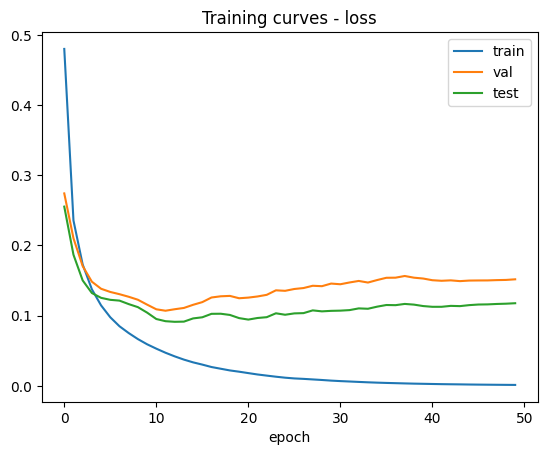

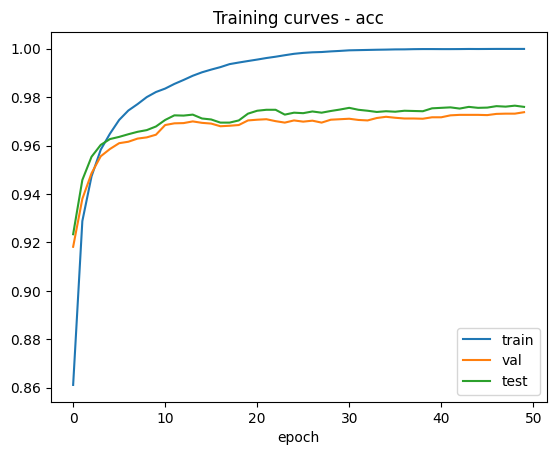

In [20]:
plot_training_curves(training_curves_two_layer, phases=['train', 'val', 'test'])

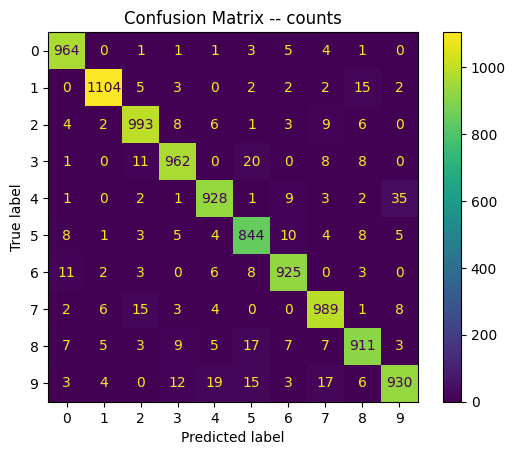

In [37]:
res = plot_cm(modelo, device, dataloaders, phase='test')

#predecimos el test de nuevo, y luego mostramos 10 imagenes para mostrarlas y en parte de arriba de cada imagen verán la prediccón del modelo

In [38]:
preds, labels, scores = classify_predictions(modelo, device, dataloaders['test'])

In [ ]:
#plt.imshow(mnist_test.data[0], cmap=plt.cm.binary)
#plt.show()

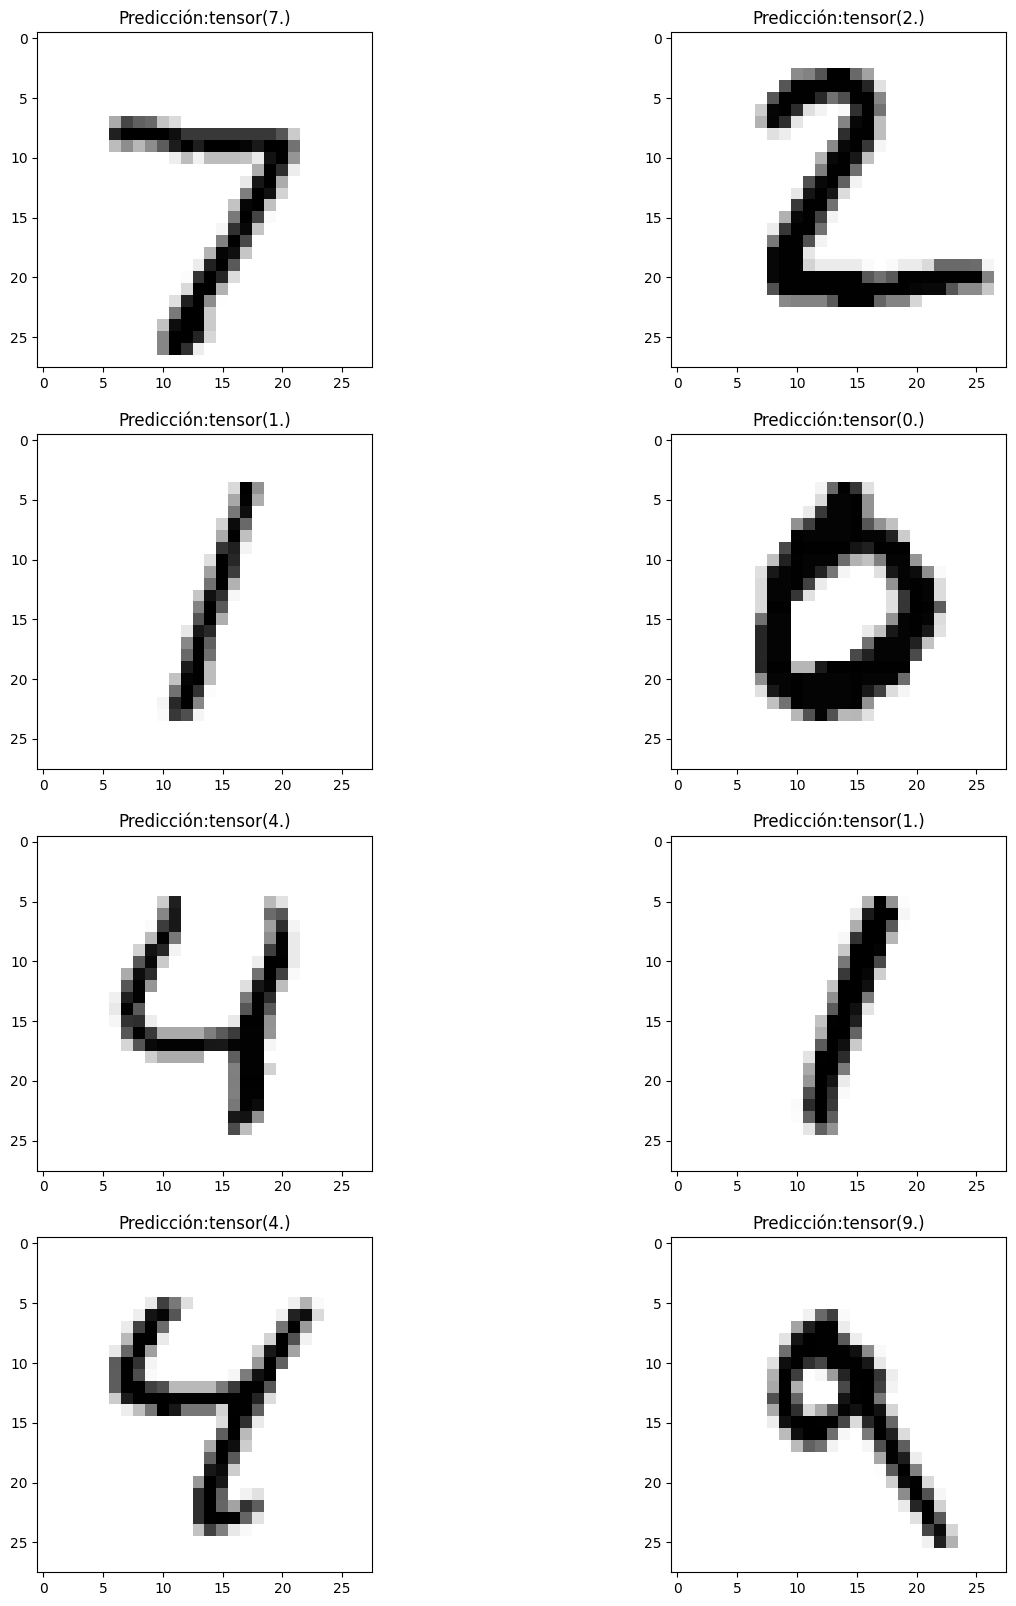

In [51]:
#fig, ax = plt.subplots(1,2, figsize=(16,8))
fig, ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
fig.set_figheight(20)
indice = 0
for i in range(4):
  for j in range(2):
    ax[i,j].imshow(mnist_test.data[indice], cmap=plt.cm.binary)
    ax[i,j].set_title('---')
    ax[i,j].set_title('Predicción:'+str(preds.data[indice]))
    indice=indice+1


